In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from IPython.display import HTML
import seaborn as sns
from matplotlib.animation import FuncAnimation
import psutil
import gc
import pandas as pd
from tqdm import tqdm
import re
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_demographics_input = pd.read_csv('../../datasets/alzheimers/demographics.csv')
df_demographics_input.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,"=RIGHT(B2,1)",0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,"=RIGHT(B3,1)",457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,"=RIGHT(B4,1)",0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,"=RIGHT(B5,1)",560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,"=RIGHT(B6,1)",1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [3]:
df_demographics_input['Age']

0      87
1      88
2      75
3      76
4      80
       ..
368    82
369    86
370    61
371    63
372    65
Name: Age, Length: 373, dtype: int64

In [4]:
df_demographics_input.shape

(373, 15)

In [19]:
# Load training data
rootdir = '../../datasets/alzheimers/training/'

dict_user = {}

# Display a progress bar using tqdm
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('nifti.img'):
            # coded mri name is something like
            # 0AS2_0079_MR1
            coded_mri_name = filepath.split('/')[-3]
            split = coded_mri_name.split('_')
            if len(split) == 3:
                user_id, mri_scan_number = split[-2:]
                if user_id in dict_user:
                    dict_user[user_id].append(filepath)
                else:
                    dict_user[user_id] = [filepath]


In [20]:
dict_user

{'0079': ['../../datasets/alzheimers/training/OAS2_0079_MR1/RAW/mpr-2.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR1/RAW/mpr-3.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR1/RAW/mpr-4.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR1/RAW/mpr-1.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR2/RAW/mpr-2.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR2/RAW/mpr-3.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR2/RAW/mpr-4.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR2/RAW/mpr-1.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR3/RAW/mpr-2.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR3/RAW/mpr-3.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0079_MR3/RAW/mpr-1.nifti.img'],
 '0073': ['../../datasets/alzheimers/training/OAS2_0073_MR4/RAW/mpr-2.nifti.img',
  '../../datasets/alzheimers/training/OAS2_0073_MR4/RAW/mpr-3.nifti.img',
  '../../datasets/alz

In [122]:
def show_user(user_id,mri_index):
    user_imgs = dict_user[user_id]
    img_data = nib.load(user_imgs[mri_index]).get_fdata()
    # transpose to rearrange dimensions for visualization
    # img_data = np.transpose(img_data,(1,0,2,3))

    plt.title(f'User: {user_id}, Scan: {mri_index}\nGroup: {df_demographics_input[df_demographics_input["Subject ID"] == f"OAS2_{user_id}"]["Group"].iloc[0]}')

    plt.imshow((img_data[:,:,75]),cmap='gray')
    plt.colorbar(label='Signal intensity')

    plt.show()
    

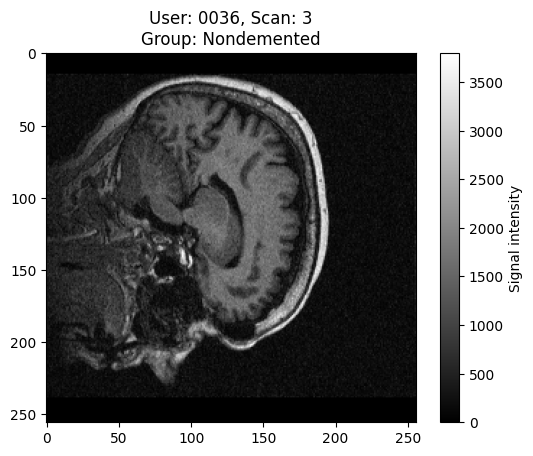

In [124]:
show_user('0036',3)

In [126]:
from tensorflow.keras import applications
# VGG16 pre-trained model without fully connected layers and with different input dimensions
input_shape = (256, 256, 3)
model = applications.VGG16(
    weights="imagenet", include_top=False, input_shape=input_shape)
model.summary()

2024-02-03 12:17:43.455634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 12:17:43.455661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 12:17:43.456698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 12:17:43.460517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 12:17:44.009073: W tensorflow/compiler/tf2

L355
2024-02-03 12:17:44.486588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 12:17:44.486761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 12:17:44.745704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
# freeze the models layers
for layer in model.layers:
    layer.trainable = False